In [9]:
import tensorflow as tf
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from ipynb.fs.full.preprocessingZindi import calc_fft
import pickle
from keras.callbacks import ModelCheckpoint
from ipynb.fs.full.cfg import Config

In [16]:
conf = tf.compat.v1.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=conf)

In [17]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



In [18]:
config = Config(mode='conv')

In [19]:
def check_data():
    if os.path.isfile(config.p_path):
        
        print('Loading existing data for {} model'. format(config.mode))
        with open(config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [20]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        print("reading temp data:")
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min,_max = float('inf'),-float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.common_name==rand_class].index)
        rate,wav = wavfile.read('./CleanedFiles/' + file + '.wav')
        label = df.at[file,'common_name']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    
    X,y = np.array(X), np.array(y)
    X =(X -_min) /(_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0],X.shape[1], X.shape[2],1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y,num_classes=40)
    config.data = (X,y)
    with open(config.p_path,'wb') as handle:
        pickle.dump(config,handle,protocol=2)
    
    return X,y

In [ ]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        print("reading temp data:")
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min,_max = float('inf'),-float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.common_name==rand_class].index)
        #rate,wav = wavfile.read('./CleanedFiles/' + file + '.wav')
        
        wav, rate = librosa.load('./CleanedFiles/' + file + '.wav')
        
        
        label = df.at[file,'common_name']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    
    X,y = np.array(X), np.array(y)
    X =(X -_min) /(_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0],X.shape[1], X.shape[2],1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y,num_classes=40)
    config.data = (X,y)
    with open(config.p_path,'wb') as handle:
        pickle.dump(config,handle,protocol=2)
    
    return X,y

In [21]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same', input_shape=input_shape))
    model.add(Conv2D(32,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same'))
    model.add(Conv2D(128,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(40, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(type(model))
    return model

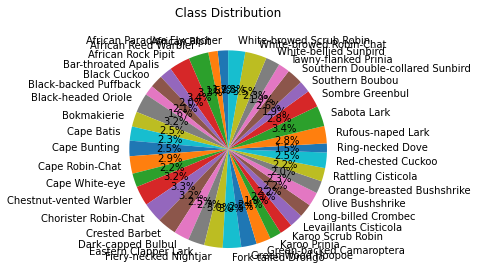

In [22]:
df = pd.read_csv('TrainZindi.csv')
df.set_index('ID', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('./CleanedFiles/'+f + '.wav')
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.common_name))
class_dist = df.groupby(['common_name'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist /class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)



fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [23]:
classes = list(np.unique(df.common_name))
len(classes)

40

In [24]:
print(choices)
print(type (choices))

Green-backed Camaroptera
<class 'str'>


In [25]:
# if config.mode == 'conv':
x,y = build_rand_feat()
y_flat = np.argmax(y,axis=1)
input_shape = (x.shape[1], x.shape[2],1)
conv_model = get_conv_model()
# elif config.mode == 'time':
#     x,y = build_rand_feat()
#     y_flat = np.argmax(y,axis=1)
#     input_shape=(x.shape[1], x.shape[2])
#     model = get_recurrent_model()

100%|█████████████████████████████| 1356202/1356202 [1:23:44<00:00, 269.91it/s]


MemoryError: 

In [26]:
x

NameError: name 'x' is not defined

In [27]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

NameError: name 'y_flat' is not defined

In [ ]:
checkpoint  = ModelCheckpoint(config.model_path, monitor='val_acc',verbose=1, mode='max', save_best_only=True
                              , save_weights_only=False,period=1)

In [ ]:
conv_model.fit(x,y,epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.1,
              callbacks=[checkpoint])

In [ ]:
conv_model.save(config.model_path)

In [ ]:
x.shape
df.head()